In [2]:
##### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import wandb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lsa64-matrix-10-classes-v1/padded_matrix_file.csv


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import csv
import ast
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

In [7]:
!pip install wandb

In [8]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
# Your code for loading the data (unchanged)
input_file = "/kaggle/input/lsa64-matrix-10-classes-v1/padded_matrix_file.csv"

values = []
matrix_labels = []
num_rows = 0

with open(input_file, "r") as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        row_values = []
        for i in range(len(row) - 1):
            column_value = ast.literal_eval(row[i])
            row_values.append(column_value)
        values.append(torch.tensor(row_values))
        matrix_labels.append(ast.literal_eval(row[-1]))
        num_rows += 1

# matrix_labels = [label - 1 for label in matrix_labels]

In [ ]:
import random
random.sample(list(set(matrix_labels)), 10)

In [10]:
def sample_triplets(data, labels):
    anchor_indices = torch.arange(len(data))
    positive_indices = torch.empty(len(data), dtype=torch.long)
    negative_indices = torch.empty(len(data), dtype=torch.long)

    for i, label in enumerate(labels):
        # Sample positive instances
        positive_candidates = (labels == label).nonzero(as_tuple=False).view(-1)
        positive_candidates = positive_candidates[positive_candidates != i]
        
        if len(positive_candidates) > 0:
            positive_indices[i] = positive_candidates[torch.randint(0, len(positive_candidates), (1,))]
        else:
            positive_indices[i] = i  
        negative_candidates = (labels != label).nonzero(as_tuple=False).view(-1)
        negative_indices[i] = negative_candidates[torch.randint(0, len(negative_candidates), (1,))]
        
    anchor = data[anchor_indices]
    positive = data[positive_indices]
    negative = data[negative_indices]
    return anchor, positive, negative

In [11]:
# Triplet loss function
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_distance = F.pairwise_distance(anchor,positive)
        neg_distance = F.pairwise_distance(anchor, negative)
        loss = F.relu(pos_distance - neg_distance + self.margin)
        return loss.mean()

In [12]:
# Define the dataset class
class SkeletonDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [13]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_features, d_model=64, nhead=32, num_layers=2):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(n_features, d_model)
        self.positional_encoding = self.generate_positional_encoding(d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_layers
        )

    def generate_positional_encoding(self, d_model, max_len=243):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding[:, : x.size(1)]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return x

In [14]:
# Split the dataset into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    torch.stack(values), torch.tensor(matrix_labels), test_size=0.4, random_state=42, stratify=torch.tensor(matrix_labels)
)

validation_data, test_data, validation_labels, test_labels = train_test_split(
    test_data, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

# Create train, validation, and test datasets
train_dataset = SkeletonDataset(train_data, train_labels)
validation_dataset = SkeletonDataset(validation_data, validation_labels)
test_dataset = SkeletonDataset(test_data, test_labels)

In [15]:
from sklearn.metrics import pairwise_distances

In [ ]:
hyperparam_sets=[]
icd_values=[]
lcd_values=[]

In [16]:

def train_model():
  config_defaults = {
      'n_epochs': 100,
      'batch_size': 32,
      'd_model': 64,
      'n_heads': 32,
      'n_layers': 1,
      'margin': 1.0
    }
  # Start W&B
  wandb.init(config=config_defaults)
  config = wandb.config

  # Create data loaders for train, validation, and test sets
  train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
  validation_loader = DataLoader(validation_dataset, batch_size=config.batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

  model = TransformerEncoder(114,config.d_model,config.n_heads,config.n_layers)
  criterion = TripletLoss(config.margin)
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_losses = []
  validation_losses = []

  num_epochs = config.n_epochs
  for epoch in range(num_epochs):
      model.train()
      epoch_train_loss = 0
      for batch_idx, (data, labels) in enumerate(train_loader):
          optimizer.zero_grad()
          anchor, positive, negative = sample_triplets(data, labels)
          anchor_embeddings = model(anchor)
          positive_embeddings = model(positive)
          negative_embeddings = model(negative)
          loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
          loss.backward()
          optimizer.step()
          epoch_train_loss += loss.item()

      epoch_train_loss /= len(train_loader)
      train_losses.append(epoch_train_loss)

      # Calculate validation loss
      model.eval()
      epoch_validation_loss = 0
      with torch.no_grad():
          for batch_idx, (data, labels) in enumerate(validation_loader):
              anchor, positive, negative = sample_triplets(data, labels)
              anchor_embeddings = model(anchor)
              positive_embeddings = model(positive)
              negative_embeddings = model(negative)
              loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
              epoch_validation_loss += loss.item()

      epoch_validation_loss /= len(validation_loader)
      validation_losses.append(epoch_validation_loss)

      print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_validation_loss:.4f}")

    # Save the model
    #     torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pt")

  # Plot training and validation losses
  plt.plot(train_losses, label="Training Loss")
  plt.plot(validation_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  model.eval()
  test_embeddings = []
  test_labels_list = []

  with torch.no_grad():
      for data, labels in test_loader:
          embeddings = model(data)
          test_embeddings.append(embeddings)
          test_labels_list.append(labels)

  test_embeddings = torch.cat(test_embeddings).cpu().numpy()
  test_labels_list = torch.cat(test_labels_list).cpu().numpy()
  
  # Calculate ICD and LCD
  icd = 0
  lcd = 0
  n_classes = len(np.unique(test_labels_list))

  for i in range(n_classes):
      class_indices = np.where(test_labels_list == i)[0]
      class_embeddings = test_embeddings[class_indices]
    
      # Calculate ICD for this class
      icd += np.mean(pairwise_distances(class_embeddings))
    
      # Calculate LCD for this class
      for j in range(i+1, n_classes):
          other_class_indices = np.where(test_labels_list == j)[0]
          other_class_embeddings = test_embeddings[other_class_indices]
          lcd += np.mean(pairwise_distances(class_embeddings, other_class_embeddings))

  icd /= n_classes
  lcd /= (n_classes * (n_classes - 1) / 2)

  # Print ICD and LCD
  print(f"ICD: {icd:.4f}")
  print(f"LCD: {lcd:.4f}")


  tsne = TSNE(n_components=3, random_state=42)
  test_embeddings_3d = tsne.fit_transform(test_embeddings)

  le = LabelEncoder()
  test_labels_int = le.fit_transform(test_labels_list)

  n_classes = 10
  n_subplots = 2
  n_classes_per_subplot = n_classes // n_subplots

  subplot_titles = [
      f"Embeddings for classes {i * n_classes_per_subplot}-{(i + 1) * n_classes_per_subplot - 1}"
      for i in range(n_subplots)
  ]
  fig = make_subplots(rows=n_subplots // 2, cols=2, specs=[[{'type': 'scatter3d'}] * 2] * (n_subplots // 2), subplot_titles=subplot_titles)

  for i in range(n_subplots):
      class_indices = np.arange(i * n_classes_per_subplot, (i + 1) * n_classes_per_subplot)

      for idx in class_indices:
          class_mask = test_labels_int == idx
          fig.add_trace(
              go.Scatter3d(
                  x=test_embeddings_3d[class_mask, 0],
                  y=test_embeddings_3d[class_mask, 1],
                  z=test_embeddings_3d[class_mask, 2],
                  mode="markers",
                  name=str(le.inverse_transform([idx])[0]),
                  marker=dict(size=3),
                  showlegend=False,
              ),
              row=i // 2 + 1,
              col=i % 2 + 1,
          )

  fig.update_layout(height=2000, width=1000, title_text="Embeddings Visualizations")
  fig.show()
  
  #2D visualizations
  tsne = TSNE(n_components=2, random_state=42)  # changed n_components to 2
  test_embeddings_2d = tsne.fit_transform(test_embeddings)  # changed variable name to test_embeddings_2d

  le = LabelEncoder()
  test_labels_int = le.fit_transform(test_labels_list)

  n_classes = 10
  n_subplots = 2
  n_classes_per_subplot = n_classes // n_subplots

  subplot_titles = [
      f"Embeddings for classes {i * n_classes_per_subplot}-{(i + 1) * n_classes_per_subplot - 1}"
      for i in range(n_subplots)
  ]
  fig = make_subplots(rows=n_subplots // 2, cols=2, specs=[[{'type': 'scatter'}] * 2] * (n_subplots // 2), subplot_titles=subplot_titles)

  for i in range(n_subplots):
      class_indices = np.arange(i * n_classes_per_subplot, (i + 1) * n_classes_per_subplot)

      for idx in class_indices:
          class_mask = test_labels_int == idx
          fig.add_trace(
              go.Scatter(
                  x=test_embeddings_2d[class_mask, 0],  # changed to use test_embeddings_2d
                  y=test_embeddings_2d[class_mask, 1],  # changed to use test_embeddings_2d
                  mode="markers",
                  name=str(le.inverse_transform([idx])[0]),
                  marker=dict(size=3),
                  showlegend=False,
              ),
              row=i // 2 + 1,
              col=i % 2 + 1,
          )

  fig.update_layout(height=400, width=600, title_text="Embeddings Visualizations (2D)")  # changed height to 1000
  fig.show()

            

In [18]:
## Define Sweep Configurations
sweep_configs = {
    "method": "grid",
    "metric": {
        "name": "f1-score",
        "goal": "maximize"
    },
    "parameters": {
        "n_epochs": {
            "values": [50,100,150]
        },
        "batch_size": {
            "values": [32]
        },
        "d_model": {
            "values": [64]
        },
        "n_heads": {
            "values": [32]
        },
        "n_layers": {
            "values": [1,2]
        },
        "margin": {
            "values": [1.0]
        }
        
    }
}

In [19]:
sweep_id = wandb.sweep(sweep=sweep_configs, project="SLSL")

Create sweep with ID: 33z8wecy
Sweep URL: https://wandb.ai/bawathra/SLSL/sweeps/33z8wecy


wandb: Agent Starting Run: 4wi0rygj with config:
wandb: 	batch_size: 32
wandb: 	d_model: 64
wandb: 	margin: 1
wandb: 	n_epochs: 50
wandb: 	n_heads: 32
wandb: 	n_layers: 1
wandb: Currently logged in as: dineth-18 (bawathra). Use `wandb login --relogin` to force relogin


Epoch 1/50, Train Loss: 0.5811, Validation Loss: 0.3219
Epoch 2/50, Train Loss: 0.4051, Validation Loss: 0.3439
Epoch 3/50, Train Loss: 0.4060, Validation Loss: 0.3410
Epoch 4/50, Train Loss: 0.3951, Validation Loss: 0.2794
Epoch 5/50, Train Loss: 0.2791, Validation Loss: 0.3309
Epoch 6/50, Train Loss: 0.2590, Validation Loss: 0.3820
Epoch 7/50, Train Loss: 0.2860, Validation Loss: 0.2668
Epoch 8/50, Train Loss: 0.2914, Validation Loss: 0.2026
Epoch 9/50, Train Loss: 0.2377, Validation Loss: 0.1861
Epoch 10/50, Train Loss: 0.1799, Validation Loss: 0.2160
Epoch 11/50, Train Loss: 0.2107, Validation Loss: 0.1636
Epoch 12/50, Train Loss: 0.2119, Validation Loss: 0.1822
Epoch 13/50, Train Loss: 0.1485, Validation Loss: 0.1506
Epoch 14/50, Train Loss: 0.1606, Validation Loss: 0.0994
Epoch 15/50, Train Loss: 0.1643, Validation Loss: 0.1876
Epoch 16/50, Train Loss: 0.1352, Validation Loss: 0.2355
Epoch 17/50, Train Loss: 0.1725, Validation Loss: 0.2029
Epoch 18/50, Train Loss: 0.1420, Validat

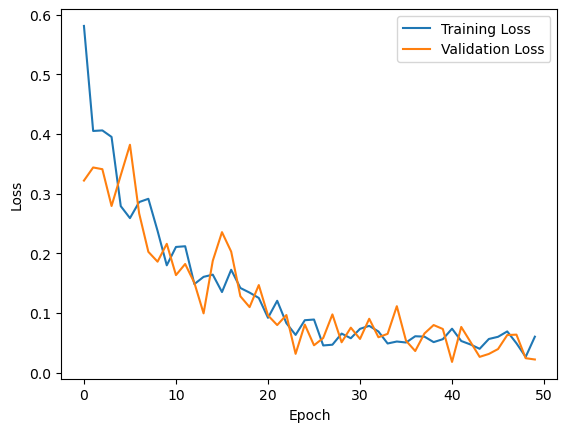

ICD: 1.1784
LCD: 4.1264


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



wandb: Agent Starting Run: bod28xv3 with config:
wandb: 	batch_size: 32
wandb: 	d_model: 64
wandb: 	margin: 1
wandb: 	n_epochs: 50
wandb: 	n_heads: 32
wandb: 	n_layers: 2


Epoch 1/50, Train Loss: 0.5850, Validation Loss: 0.3657
Epoch 2/50, Train Loss: 0.5028, Validation Loss: 0.3353
Epoch 3/50, Train Loss: 0.4568, Validation Loss: 0.2676
Epoch 4/50, Train Loss: 0.4003, Validation Loss: 0.3421
Epoch 5/50, Train Loss: 0.3656, Validation Loss: 0.2977
Epoch 6/50, Train Loss: 0.2517, Validation Loss: 0.2566
Epoch 7/50, Train Loss: 0.2858, Validation Loss: 0.3055
Epoch 8/50, Train Loss: 0.2841, Validation Loss: 0.2006
Epoch 9/50, Train Loss: 0.2759, Validation Loss: 0.1601
Epoch 10/50, Train Loss: 0.2441, Validation Loss: 0.1075
Epoch 11/50, Train Loss: 0.1736, Validation Loss: 0.1896
Epoch 12/50, Train Loss: 0.2044, Validation Loss: 0.1696
Epoch 13/50, Train Loss: 0.1617, Validation Loss: 0.2114
Epoch 14/50, Train Loss: 0.1936, Validation Loss: 0.1757
Epoch 15/50, Train Loss: 0.1218, Validation Loss: 0.2104
Epoch 16/50, Train Loss: 0.1429, Validation Loss: 0.1968
Epoch 17/50, Train Loss: 0.1359, Validation Loss: 0.1161
Epoch 18/50, Train Loss: 0.1367, Validat

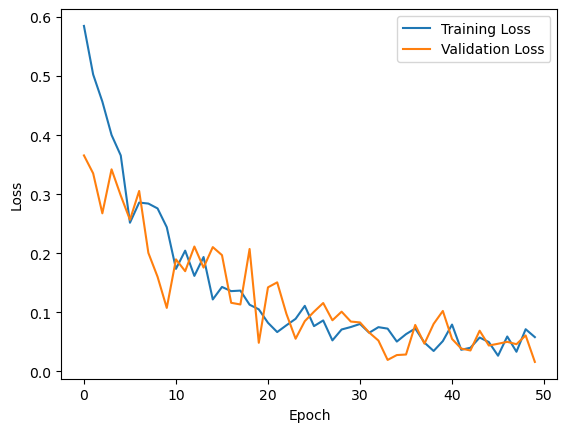

ICD: 1.2052
LCD: 4.4020


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



wandb: Agent Starting Run: tfh2qb5d with config:
wandb: 	batch_size: 32
wandb: 	d_model: 64
wandb: 	margin: 1
wandb: 	n_epochs: 100
wandb: 	n_heads: 32
wandb: 	n_layers: 1


Epoch 1/100, Train Loss: 0.5491, Validation Loss: 0.2930
Epoch 2/100, Train Loss: 0.4231, Validation Loss: 0.3845
Epoch 3/100, Train Loss: 0.3580, Validation Loss: 0.4344
Epoch 4/100, Train Loss: 0.4232, Validation Loss: 0.2661
Epoch 5/100, Train Loss: 0.3381, Validation Loss: 0.2363
Epoch 6/100, Train Loss: 0.3055, Validation Loss: 0.3419
Epoch 7/100, Train Loss: 0.2873, Validation Loss: 0.2987
Epoch 8/100, Train Loss: 0.2620, Validation Loss: 0.2127
Epoch 9/100, Train Loss: 0.2560, Validation Loss: 0.3357
Epoch 10/100, Train Loss: 0.2926, Validation Loss: 0.1637
Epoch 11/100, Train Loss: 0.1772, Validation Loss: 0.2399
Epoch 12/100, Train Loss: 0.2210, Validation Loss: 0.2294
Epoch 13/100, Train Loss: 0.2001, Validation Loss: 0.1090
Epoch 14/100, Train Loss: 0.1738, Validation Loss: 0.1036
Epoch 15/100, Train Loss: 0.1506, Validation Loss: 0.1571
Epoch 16/100, Train Loss: 0.1292, Validation Loss: 0.1155
Epoch 17/100, Train Loss: 0.1047, Validation Loss: 0.1792
Epoch 18/100, Train Los

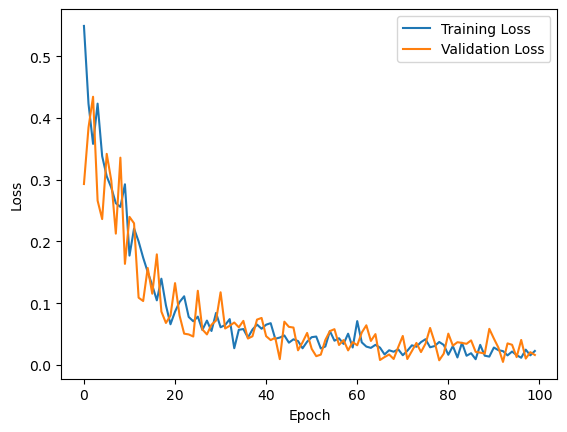

ICD: 1.5499
LCD: 4.4127


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



wandb: Agent Starting Run: 03w32ig0 with config:
wandb: 	batch_size: 32
wandb: 	d_model: 64
wandb: 	margin: 1
wandb: 	n_epochs: 100
wandb: 	n_heads: 32
wandb: 	n_layers: 2


Epoch 1/100, Train Loss: 0.6269, Validation Loss: 0.5083
Epoch 2/100, Train Loss: 0.5515, Validation Loss: 0.3268
Epoch 3/100, Train Loss: 0.4461, Validation Loss: 0.3118
Epoch 4/100, Train Loss: 0.4074, Validation Loss: 0.2956
Epoch 5/100, Train Loss: 0.2705, Validation Loss: 0.3079
Epoch 6/100, Train Loss: 0.3104, Validation Loss: 0.3253
Epoch 7/100, Train Loss: 0.2086, Validation Loss: 0.3581
Epoch 8/100, Train Loss: 0.3225, Validation Loss: 0.4097
Epoch 9/100, Train Loss: 0.2244, Validation Loss: 0.2639
Epoch 10/100, Train Loss: 0.1977, Validation Loss: 0.2924
Epoch 11/100, Train Loss: 0.3555, Validation Loss: 0.2829
Epoch 12/100, Train Loss: 0.2252, Validation Loss: 0.2257
Epoch 13/100, Train Loss: 0.1986, Validation Loss: 0.1542
Epoch 14/100, Train Loss: 0.1696, Validation Loss: 0.2248
Epoch 15/100, Train Loss: 0.1277, Validation Loss: 0.3681
Epoch 16/100, Train Loss: 0.1346, Validation Loss: 0.1726
Epoch 17/100, Train Loss: 0.2262, Validation Loss: 0.1072
Epoch 18/100, Train Los

In [ ]:
wandb.agent(sweep_id=sweep_id, function=train_model)

In [ ]:
import numpy as np

def find_best_hyperparams(hyperparam_sets, icd_values, lcd_values):
    assert len(hyperparam_sets) == len(icd_values) == len(lcd_values)
    
    best_idx = None
    best_icd = np.inf
    best_lcd = -np.inf
    
    for i in range(len(hyperparam_sets)):
        icd = icd_values[i]
        lcd = lcd_values[i]
        
        if icd < best_icd or (icd == best_icd and lcd > best_lcd):
            best_icd = icd
            best_lcd = lcd
            best_idx = i
    
    return hyperparam_sets[best_idx]


In [ ]:
best_hyperparams = find_best_hyperparams(hyperparam_sets, icd_values, lcd_values)


In [ ]:
best_hyperparams